# NLP for wine classification based on their review

Data can be found [here](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Some EDA

In [24]:
df = pd.read_csv('winemag-data-130k-v2.csv')
print(df.shape)
df.head()

(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
df.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

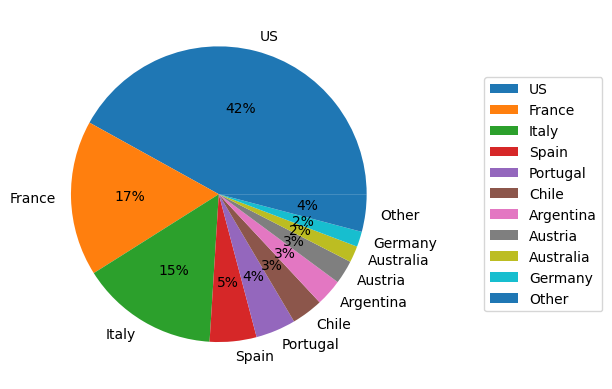

In [4]:
# display percentage by country
df_bycountry = df['country'].value_counts().to_frame()
tot_others = df_bycountry[df_bycountry['country'] < 2000].sum()
df_bycountry = df_bycountry.drop(df_bycountry[df_bycountry['country'] < 2000].index)
df_bycountry.loc['Other'] = tot_others
df_bycountry.plot.pie(y='country', ylabel='', autopct='%1.0f%%')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))

<AxesSubplot:>

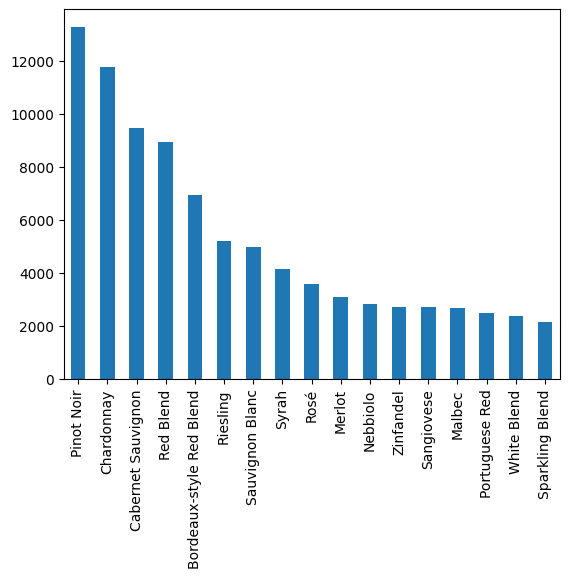

In [5]:
# display histogram by variety, filter variety with less than 2000 reviews
df_byvariety = df['variety'].value_counts().to_frame()
df_byvariety = df_byvariety.drop(df_byvariety[df_byvariety['variety'] < 2000].index)
df_byvariety.plot(kind='bar', legend=False)

<AxesSubplot:title={'center':'points'}, xlabel='variety'>

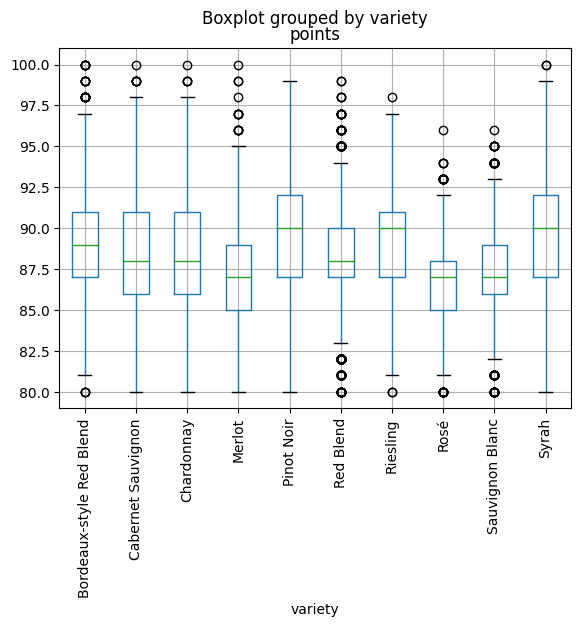

In [6]:
# average points for 10 most occurring varieties
df_points = df.set_index('variety').loc[df_byvariety[:10].index]
df_points.reset_index(names=['variety']).boxplot(column='points', by='variety', rot=90)

Text(0, 0.5, 'Price [currency ?]')

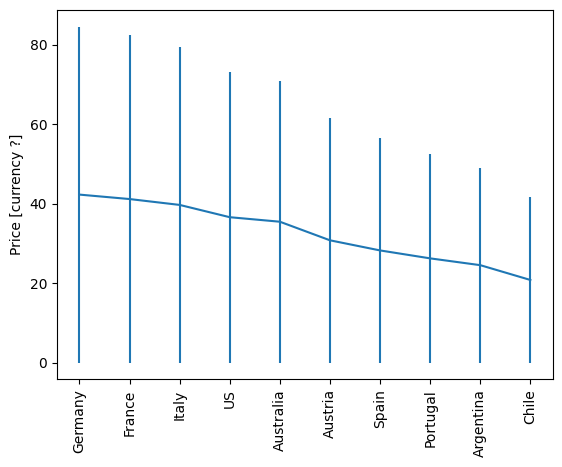

In [7]:
# average price by country
df_price = df.groupby('country')['price'].mean().loc[df_bycountry[:10].index].to_frame()
df_price['std'] = df.groupby('country')['price'].std().loc[df_bycountry[:10].index]
df_price.sort_values(by='price', ascending=False, inplace=True)

plt.errorbar(df_price.index, df_price['price'], yerr=df_price['price'])
plt.xticks(rotation=90)
plt.ylabel("Price [currency ?]")

In [8]:
# most occurring variety by country
df_variety_by_country = df.groupby(['country'])['variety'].agg(pd.Series.mode).to_frame()
df_variety_by_country.loc[df_bycountry[:10].index]

,variety
US,Pinot Noir
France,Bordeaux-style Red Blend
Italy,Red Blend
Spain,Tempranillo
Portugal,Portuguese Red
Chile,Cabernet Sauvignon
Argentina,Malbec
Austria,Grüner Veltliner
Australia,Shiraz
Germany,Riesling


## Data Cleaning

In [85]:
# keep only description and variety
ndf = df[['description', 'variety']]
ndf.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir


In [86]:
# let's keep only the 10 most occurring varieties
most_ocurring_varieties = ndf['variety'].value_counts()[:10]
most_ocurring_varieties

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Riesling                     5189
Sauvignon Blanc              4967
Syrah                        4142
Rosé                         3564
Merlot                       3102
Name: variety, dtype: int64

In [87]:
# keep only most occurring varieties
ndf = ndf[ndf['variety'].isin(most_ocurring_varieties.index)]
print(ndf.shape)
ndf.head()

(71322, 2)


,description,variety
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon
14,Building on 150 years and six generations of w...,Chardonnay


## Feature Extraction with Bag of Words

Let's try without text pre-processing first.
Then add the text pre-processing and see if there is improvement.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(ndf['description'])
x_train, x_test, y_train, y_test = train_test_split(x_train_counts, ndf['variety'], test_size=0.3)

In [18]:
clf = MultinomialNB().fit(x_train, y_train)
predictions = clf.predict(x_test)
accuracy_score(y_test, predictions)

0.7287937561340375

In [21]:
clf2 = SVC(kernel='linear').fit(x_train, y_train)
predictions = clf2.predict(x_test)
accuracy_score(y_test, predictions)

0.7769313455157265

This is a pretty good result.
Let's see now what happens when we add pre-processing of the text.

In [44]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

In [88]:
ndf.head()

,description,variety
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon
14,Building on 150 years and six generations of w...,Chardonnay


In [89]:
# make lower case
ndf['description'] = ndf['description'].apply(lambda x: x.lower())

# remove digits
ndf['description'] = ndf['description'].map(lambda m: re.sub(r"\d", " ", m))

# remove punctuation (includes symbols)
pattern = r'[' + string.punctuation + ']'
ndf['description'] = ndf['description'].map(lambda m: re.sub(pattern, " ", m))

# tokenize
ndf['description'] = ndf['description'].apply(lambda x: x.split())

# remove stopwords
sw = nltk.corpus.stopwords.words('english')
ndf['description'] = ndf['description'].apply(lambda x: [item for item in x if item not in sw])

# lemmatize
ndf['description'] = ndf['description'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

# join
ndf['description']= ndf['description'].apply(lambda x: ' '.join(x))

ndf.head()

,description,variety
3,pineapple rind lemon pith orange blossom start...,Riesling
4,much like regular bottling come across rather ...,Pinot Noir
10,soft supple plum envelope oaky structure caber...,Cabernet Sauvignon
12,slightly reduced wine offer chalky tannic back...,Cabernet Sauvignon
14,building year six generation winemaking tradit...,Chardonnay


In [90]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(ndf['description'])
x_train, x_test, y_train, y_test = train_test_split(x_train_counts, ndf['variety'], test_size=0.3)

In [91]:
clf = MultinomialNB().fit(x_train, y_train)
predictions = clf.predict(x_test)
accuracy_score(y_test, predictions)

0.7365518530635136

In [92]:
clf2 = SVC(kernel='linear').fit(x_train, y_train)
predictions = clf2.predict(x_test)
accuracy_score(y_test, predictions)

0.7782866757022012

## Conclusion

The scores for both the Multinomial Naive Bayes and Support Vector Machine were fairly good.
The pre-processing of the text did not have a strong impact on the accuracy.